In [1]:
!pip install -q --upgrade flax optax rdkit tokenizers jax_tqdm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.21.3 requires tokenizers!=0.11.3,<0.13,>=0.11.1, but you have tokenizers 0.15.2 which is incompatible.


In [3]:
gpu_test = jnp.array([0,1,2])
gpu_test.devices()

2024-03-27 14:07:23.904524: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{cuda(id=0)}

In [2]:
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
from flax import struct
import optax
from jax_tqdm import scan_tqdm

# imoprt models from models.py
from models import Transformer, Encoder, TransformerConfig

# Viz
import matplotlib.pyplot as plt

# for use with loading and manipulating SMILES strings
import sklearn
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# for preprocessor training/tokenizing data
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

# Training a Tokenizer on QM9 Smiles Strings.

In [55]:
sample = pd.read_csv("train.csv")

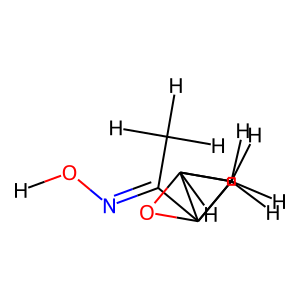

In [71]:
sample = "[H]O/N=C(\C([H])([H])[H])C123OC1([H])(C2([H])[H])C3([H])[H]"
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles(sample, sanitize=False)
Draw.MolToImage(mol, size=(300, 300))


In [3]:
def load_data(name):
    data = pd.read_csv(name)
    return data.pop("smiles"), data

In [4]:
def to_jax(tokenized):
    tokens = [np.array(t.ids, dtype=np.uint8) for t in tokenized]
    attn = [np.array(t.attention_mask, dtype=np.uint8) for t in tokenized]
    return jnp.array(tokens), jnp.array(attn)

In [113]:
def sanitize_data(smiles_with_h, properties):
    # Convert the SMILES string to an RDKit molecule object
    mols = smiles_with_h.map(Chem.MolFromSmiles)

    na_indexes = mols[mols.isna()].index
    properties_cleaned = properties.drop(index=na_indexes)
    mols = mols.dropna()
    
    # Remove explicit hydrogens
    mols_no_h = mols.map(Chem.RemoveHs)
    
    # Convert back to SMILES string
    return mols_no_h.map(Chem.MolToSmiles), properties_cleaned

In [120]:
x, y = sanitize_data(*load_data("train.csv"))

[13:21:10] Explicit valence for atom # 4 C, 5, is greater than permitted
[13:21:10] Explicit valence for atom # 4 C, 5, is greater than permitted
[13:21:10] Explicit valence for atom # 5 C, 5, is greater than permitted
[13:21:10] Explicit valence for atom # 5 C, 5, is greater than permitted
[13:21:10] Explicit valence for atom # 7 C, 5, is greater than permitted
[13:21:10] Explicit valence for atom # 7 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 4 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:21:11] Explicit valence for atom # 6 C, 5, is g

In [121]:
y.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000,109643.000000
mean,2.707669,76.845453,-6.518896,0.278505,6.797396,1232.369907,4.123326,-11419.300932,-11419.066347,-11419.040658,-11420.216138,32.247278,-77.537392,-78.009675,-78.455363,-72.154212,3.206839,1.325939,1.062998
std,1.518359,7.158100,0.595401,1.268800,1.275416,266.137497,0.896780,905.090977,905.091074,905.091076,905.096400,3.764701,9.773674,9.864881,9.937176,8.984342,1.274006,0.366953,0.261369
min,0.000000,27.490000,-10.783872,-4.680358,0.669400,619.581600,0.801022,-19444.387000,-19444.172000,-19444.146000,-19445.314000,17.478000,-113.113150,-113.891940,-114.611730,-104.816420,1.382500,0.337120,0.331180
25%,1.596700,72.230000,-6.859990,-0.658516,5.864054,1060.317250,3.469411,-11948.118500,-11947.880500,-11947.854750,-11949.039000,29.635000,-83.883642,-84.416627,-84.907640,-78.007990,2.484675,1.062095,0.891020
50%,2.510700,76.840000,-6.547059,0.296604,6.737539,1176.241500,4.079504,-11475.592000,-11475.393000,-11475.366000,-11476.455000,32.111000,-77.577160,-78.049150,-78.489510,-72.220410,2.960920,1.328180,1.043770
75%,3.632000,81.505000,-6.209638,1.270772,7.787898,1336.864450,4.696808,-10865.747500,-10865.482000,-10865.456500,-10866.695500,34.727000,-71.238689,-71.650543,-72.049692,-66.357460,3.591745,1.587005,1.222570
max,29.556400,196.620000,-2.767398,2.908897,13.066907,3374.753200,7.454396,-9293.555000,-9293.405000,-9293.379000,-9294.354500,46.969000,-31.838657,-31.986961,-32.166748,-29.434204,159.871170,2.707610,2.468570


In [122]:
x[3]

'C#CCn1nnnn1'

QM9 only contains CHONF molecules, meaning we don't have to do fancy tokenization to keep letters of atoms together. We'll do BPE tokenization and set a minimum frequency of 1,000 to only capture motifs of molecule structure without over-memorizing the molecules. The choic of 1,000 was arbitrary and might need tuned down a little bit.

In [132]:
# Initialize a tokenizer
tokenizer = Tokenizer(BPE())

# Use whitespace pre-tokenizer

# Initialize a trainer with your desired settings
trainer = BpeTrainer(special_tokens=["[PAD]"], min_frequency=600, show_progress=True)

# Train your tokenizer on a list of files
tokenizer.train_from_iterator(x, trainer)
tokenizer.enable_padding(pad_id=0, pad_token="[PAD]")

print(tokenizer.get_vocab_size())

# Save the tokenizer for later use
tokenizer.save("./bpe.tokenizer.json")




250


In [27]:
csv_file_paths = ["train.csv", "val.csv", "test.csv"]

df_combined = pd.concat([pd.read_csv(f) for f in csv_file_paths], ignore_index=True)

# Write the concatenated DataFrame to a new CSV file
df_combined.to_csv('full.csv', index=False)

## Demonstration of ECFP4 shortcoming

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Define the SMILES for hexane, heptane, and octane
smiles_list = ["CCCCCC", "CCCCCCC", "CCCCCCCC"]

# Initialize a dictionary to hold the molecule objects
molecules = {name: Chem.MolFromSmiles(smiles) for name, smiles in zip(["Hexane", "Heptane", "Octane"], smiles_list)}

# Compute ECFP4 fingerprints
ecfp4_fingerprints = {name: AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=24) for name, mol in molecules.items()}

# Convert fingerprints to bit strings or numpy arrays for further analysis
ecfp4_bit_strings = {name: fp.ToBitString() for name, fp in ecfp4_fingerprints.items()}
ecfp4_np_arrays = {name: np.array(fp) for name, fp in ecfp4_fingerprints.items()}

# Printing bit strings for demonstration
for name, bit_string in ecfp4_bit_strings.items():
    print(f"ECFP4 for {name}:", bit_string)


ECFP4 for Hexane: 100000010110000100001010
ECFP4 for Heptane: 100000010110000100001010
ECFP4 for Octane: 100000010110000100001010


## Dataloading and processing utilities

In [4]:
def load_data(name):
    data = pd.read_csv(name)
    return data.pop("smiles"), data

In [5]:
def sanitize_data(smiles_with_h, properties):
    # Convert the SMILES string to an RDKit molecule object
    mols = smiles_with_h.map(Chem.MolFromSmiles)

    na_indexes = mols[mols.isna()].index
    properties_cleaned = properties.drop(index=na_indexes)
    mols = mols.dropna()
    
    # Remove explicit hydrogens
    mols_no_h = mols.map(Chem.RemoveHs)
    
    m2s = lambda x : Chem.MolToSmiles(x, doRandom=True, canonical=False)
    
    # Convert back to SMILES string
    return mols_no_h.map(m2s), properties_cleaned

In [6]:
def to_jax(tokenized):
    tokens = [np.array(t.ids, dtype=np.uint8) for t in tokenized]
    jax_tokens = jnp.array(tokens)
    attn_masks = nn.make_attention_mask(
        jax_tokens > 0, jax_tokens > 0, dtype=jnp.uint8
    )
    return jax_tokens, attn_masks

In [7]:
def mean_absolute_error(y_true, y_pred):
    return jnp.mean(jnp.abs(y_true - y_pred))

In [8]:
def mean_mad(x):
    x_mean = jnp.mean(x, axis=0)
    return x_mean, jnp.mean(jnp.abs(x - x_mean), axis=0)

In [9]:
def standardize_array(arr):
    arr_mean, arr_mad = mean_mad(arr)
    standardized_arr = (arr - arr_mean) * (1. / arr_mad)
    return standardized_arr, arr_mean, arr_mad


In [10]:
def load_and_preprocess_data(data_fpath, tokenizer_fpath, standardize=True, aug=0):
    # load data from csv
    smiles, properties = sanitize_data(*load_data(data_fpath))
    if data_fpath == "train.csv":
        for a in range(aug):
            s, p = sanitize_data(*load_data(data_fpath))
            smiles = smiles.append(s)
            properties = properties.append(p)
    
    
    # Standardize target values
    targets = jnp.array(properties[["0","1","2","3","4","5","6","12","13","14","15","11"]])
    mean, stddev = None, None
    if standardize:
        targets, mean, stddev = standardize_array(targets)
    
    # load tokenizer from json
    tokenizer = Tokenizer.from_file(tokenizer_fpath)
    # tokenize entire dataset
    tokenized = tokenizer.encode_batch(smiles)
    
    # convert dataset to JAX arrays
    data_array, attention_masks = to_jax(tokenized)
    
    return data_array, attention_masks, targets, mean, stddev

In [11]:
def shuffler(dataset, batch_size, pretraining = True):

    cutoff = (dataset.shape[0] // batch_size) * batch_size
    data_shape = (-1, batch_size) + dataset.shape[1:]

    def pretraining_shuffle(dataset, shuffle_rng):

        indices = jax.random.permutation(shuffle_rng, dataset.shape[0])[:cutoff]
        shuffled_dataset = dataset[indices]

        shuffled_batches = jnp.reshape(shuffled_dataset, data_shape)

        return shuffled_batches
    
    def supervised_shuffle(dataset, shuffle_rng):

        inputs, targets = dataset
        
        indices = jax.random.permutation(shuffle_rng, inputs.shape[0])[:cutoff]
        shuffled_inputs = inputs[indices]
        shuffled_targets = targets[indices]

        shuffled_inputs = jnp.reshape(shuffled_inputs, data_shape)
        shuffled_targets = jnp.reshape(shuffled_targets, 
                                       (-1, batch_size, shuffled_targets.shape[-1]))

        return (shuffled_inputs, shuffled_targets)
    
    if pretraining:
        return jax.jit(pretraining_shuffle)
    else:
        return jax.jit(supervised_shuffle)

## Target data statistics computation

In [10]:
_, _, _, full_mean, full_mad = load_and_preprocess_data("full.csv", "bpe.tokenizer.json")


[11:09:45] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 7 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 7 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 4 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 5 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:09:45] Explicit valence for atom # 6 C, 5, is g

In [36]:
for i, t in enumerate(full_mean):
    print(i, t)

0 2.6766443
1 75.30363
2 -6.537431
3 0.31492442
4 6.8523517
5 1190.8451
6 4.058648
7 -76.14261
8 -76.60702
9 -77.044914
10 -70.862175
11 31.640858


In [37]:
for i, t in enumerate(full_mad):
    print(i, t)

0 1.1725483
1 6.3008146
2 0.44153383
3 1.0494833
4 1.0737883
5 202.8534
6 0.71872246
7 8.135128
8 8.208882
9 8.267922
10 7.479108
11 3.2092192


In [12]:
TRAIN_X, TRAIN_M, TRAIN_Y, TRAIN_MEAN, TRAIN_MAD = load_and_preprocess_data("train.csv", "bpe.tokenizer.json")
VAL_X, VAL_M, VAL_Y, _, _ = load_and_preprocess_data("val.csv", "bpe.tokenizer.json", False)
TEST_X, TEST_M, TEST_Y, _, _ = load_and_preprocess_data("test.csv", "bpe.tokenizer.json", False)
VAL_Y = (VAL_Y - TRAIN_MEAN) / TRAIN_MAD
TEST_Y = (TEST_Y - TRAIN_MEAN) / TRAIN_MAD

[14:08:23] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 2 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:08:23] Explicit valence for atom # 8 C, 5, is g

In [13]:
TRAIN_X.devices()

{cuda(id=0)}

In [15]:
TRAIN_Y.shape

(109624, 12)

In [14]:
VAL_X.shape

(9918, 20)

In [16]:
for i, t in enumerate(TRAIN_MEAN):
    print(i, t)

0 2.6760945
1 75.30747
2 -6.537358
3 0.3136518
4 6.851002
5 1191.1666
6 4.0578184
7 -76.13918
8 -76.60351
9 -77.04136
10 -70.85925
11 31.642263


In [18]:
for i, s in enumerate(TRAIN_MAD):
    print(i, s)

0 1.1707302
1 6.3042417
2 0.4412381
3 1.0495086
4 1.0732853
5 202.96431
6 0.7195255
7 8.142434
8 8.216277
9 8.2753935
10 7.4855447
11 3.2098126


## Instantiate SMILES Transformer and train it

In [19]:
st_config = TransformerConfig(
    vocab_size = 250,
    output_vocab_size = 250, # make this programmatic.
    emb_dim = 256,
    num_heads = 16,
    num_layers = 4,
    qkv_dim = 256,
    mlp_dim = 256,
    max_len = 24,
    deterministic = False
)

ST = Transformer(st_config)

sample_rng = jax.random.PRNGKey(0)
# uncomment below and modify training loop to use dropout in training.
init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}


sample_batches = shuffler(TRAIN_X, 128)(TRAIN_X, sample_rng)

st_params = jax.jit(ST.init)(init_rngs, sample_batches[0], sample_batches[0])

In [16]:
TRAIN_X.shape

(109643, 23)

In [20]:

# The ST paper trained for 5 epochs on 860k molecules, so we'll train for 3 epochs on 110k molecules
def pretrain_smiles_transformer(net, net_params, epochs=40, batch_size=128, schedule=3e-4):

    ################################################
    ### Create our optimizer and other utilities ###
    ################################################

    # create optimizer
    opt = optax.adam(learning_rate = schedule)
    # create and initialize the optimizer
    opt_state = opt.init(net_params)
    
    shuffle = shuffler(TRAIN_X, 128)
    
    ######################################################################
    ### Define our ST forward pass/gradient computation                ###
    ######################################################################
    def _net_eval(smoothing=0.0):
        V_size = 250 #tokenizer.get_vocab_size() # fix this in a moment
        
        def _loss(weights, data, apply_rng):
            logits = net.apply(weights, data, data, rngs={"dropout":apply_rng})
            labels = optax.smooth_labels(jax.nn.one_hot(data, V_size), smoothing)
            return jnp.mean(optax.softmax_cross_entropy(logits, labels))
            
        return jax.jit(_loss)

    net_eval = jax.value_and_grad(_net_eval())
    
    #########################################################################
    ### Define our train step function that computes grad and updates opt ###
    #########################################################################
    
    @jax.jit
    def train_step(state, data):
        # unpack the parameters and optimizer state
        grad_params, opt_state, local_rng = state
        local_rng, apply_rng = jax.random.split(local_rng)
        # compute loss and gradient
        loss, grads = net_eval(grad_params, data, apply_rng)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state, local_rng]
        return new_state, loss
    
    
    #####################################################################
    ### Define our val step function that computes validation metrics ###
    #####################################################################
    
    # For validation epochs, do the same as before but compute the
    # accuracy (no gradients needed)
    # maybe adjust this to just compute on full Val batch all at once... (may not need adjusted)
    @jax.jit
    def eval_step(grad_params, data):
        # apply the network to the data
        logits = net.apply(grad_params, data, data, rngs={"dropout":jax.random.PRNGKey(0)})
        # compute accuracy, predictions, and loss
        acc = jnp.mean(jnp.argmax(logits, axis=-1) == data)
        # we return the parameters here because of how jax.scan is structured.
        return acc
    
    
    ##################################################################################
    ### Define our epoch function which will run the training step and compute acc ###
    ##################################################################################
    
    rng = jax.random.PRNGKey(0)
    
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state

        # Shuffle the data
        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        epoch_rng, shuffle_rng = jax.random.split(shuffle_rng)
        train_data = shuffle(TRAIN_X, shuffle_rng)

        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# our function which computes and updates gradients for one batch
            [curr_params, curr_opt_state, epoch_rng], # initialize with parameters and optimizer state of current epoch
            train_data,# pass the newly shuffled training data
        )

        new_params, _, _ = end_state

        # val epoch
        val_metrics = eval_step(new_params, VAL_X)


        return end_state[:-1], jnp.array([jnp.mean(train_loss), val_metrics])
    # end epoch

    ##################################################################################
    ### Invoke our training loop by scanning the epoch function over the data!     ###
    ##################################################################################

    final_state, metrics = jax.lax.scan(
        epoch,
        [net_params, opt_state], # metric arrays
        jnp.arange(epochs), #
    )


    final_params, final_optimizer_state = final_state

    # return our final, optimized network.
    return final_params, metrics

In [21]:
optimized_st_params, metrics = pretrain_smiles_transformer(ST, st_params, epochs=3, batch_size=256)

  0%|          | 0/3 [00:00<?, ?it/s]

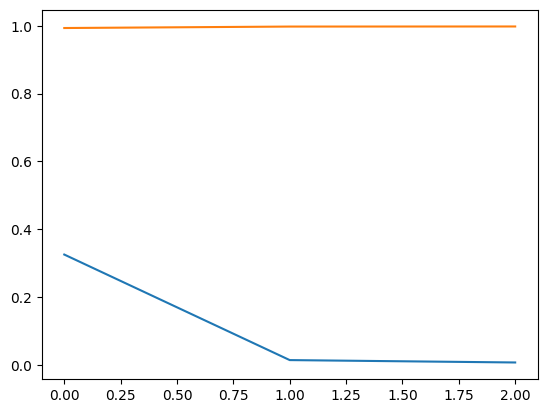

In [22]:
plt.plot(metrics)
plt.show()

In [23]:
metrics

Array([[0.3253091 , 0.9935421 ],
       [0.01395133, 0.9978373 ],
       [0.00691125, 0.9980944 ]], dtype=float32)

## Build 3 \& 4 layer encoders to generate neural fingerprints

In [24]:
def drop_layer(original_dict, keys_to_remove):
    return {key: value for key, value in original_dict.items() if key not in keys_to_remove}

In [25]:
enc_params_A = {"params" : optimized_st_params["params"]["encoder"]}
enc_params_B = {"params" : drop_layer(optimized_st_params["params"]["encoder"], ["encoderblock_3"])}

In [26]:
@jax.jit
def to_fingerprint(embedding_sequences):
    mean_pool = jnp.mean(embedding_sequences, axis=-2)
    max_pool = jnp.max(embedding_sequences, axis=-2)
    return jnp.concatenate([mean_pool, max_pool], axis=-1)

In [27]:
# clean this up and turn into a function/routine.
# need to put encoder in deterministic mode...
enc_config_A = TransformerConfig(
    #dtype=jnp.float16,
    vocab_size = 250,
    output_vocab_size = 250, # make this programmatic.
    emb_dim = 256,
    num_heads = 16,
    num_layers = 4,
    qkv_dim = 256,
    mlp_dim = 256,
    max_len = 24,
    deterministic = True
)

enc_config_B = TransformerConfig(
    #dtype=jnp.float16,
    vocab_size = 250,
    output_vocab_size = 250, # make this programmatic.
    emb_dim = 256,
    num_heads = 16,
    num_layers = 3,
    qkv_dim = 256,
    mlp_dim = 256,
    max_len = 24,
    deterministic = True
)


E1 = Encoder(enc_config_A)
E2 = Encoder(enc_config_B)

# TRAIN_X = data, TRAIN_M = attention masks
TRAIN_X_ENC_A = to_fingerprint(E1.apply(enc_params_A, TRAIN_X, encoder_mask=TRAIN_M))
TRAIN_X_ENC_B = to_fingerprint(E2.apply(enc_params_B, TRAIN_X, encoder_mask=TRAIN_M))

TRAIN_FPRINTS = jnp.concatenate([TRAIN_X_ENC_A, TRAIN_X_ENC_B], axis=-1)

VAL_X_ENC_A = to_fingerprint(E1.apply(enc_params_A, VAL_X, encoder_mask=VAL_M))
VAL_X_ENC_B = to_fingerprint(E2.apply(enc_params_B, VAL_X, encoder_mask=VAL_M))

VAL_FPRINTS = jnp.concatenate([VAL_X_ENC_A, VAL_X_ENC_B], axis=-1)

TEST_X_ENC_A = to_fingerprint(E1.apply(enc_params_A, TEST_X, encoder_mask=TEST_M))
TEST_X_ENC_B = to_fingerprint(E2.apply(enc_params_B, TEST_X, encoder_mask=TEST_M))

TEST_FPRINTS = jnp.concatenate([TEST_X_ENC_A, TEST_X_ENC_B], axis=-1)

In [28]:
TRAIN_FPRINTS.shape

(109624, 1024)

## Train MLP regression models for each DFT target

In [29]:
class MLP(nn.Module):                    # notsure if this is a good architecture. maybe add skip connections??
    out_dims: int

    @nn.compact
    def __call__(self, x, train):
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(512)(x)                 # create inline Flax Module submodules
        x = nn.Dropout(0.2, deterministic=not train)(x)
        x = nn.relu(x)
        x = nn.Dense(512)(x)                 # create inline Flax Module submodules
        x = nn.Dropout(0.2, deterministic=not train)(x)
        x = nn.relu(x)
        x = nn.Dense(512)(x)                 # create inline Flax Module submodules
        x = nn.Dropout(0.2, deterministic=not train)(x)
        x = nn.relu(x)
        x = nn.Dense(self.out_dims)(x)       # shape inference
        return x

QM9_net = MLP(out_dims=1)                 # instantiate the MLP model

sample_batches = shuffler(TRAIN_FPRINTS, 128, pretraining=False)((TRAIN_FPRINTS,TRAIN_Y),
                                                                 jax.random.PRNGKey(0))[0]
QM9_params = QM9_net.init(jax.random.PRNGKey(42), sample_batches[0], train=False)

In [30]:
# The ST paper trained for 5 epochs on 860k molecules, so we'll train for 4 epochs on 110k molecules
def train_QM9_predictor(net, net_params, TARGET_LABEL = 0, eval_tgt_x=VAL_FPRINTS, eval_tgt_y=VAL_Y, epochs=40, batch_size=128, schedule=2e-4):

    ################################################
    ### Create our optimizer and other utilities ###
    ################################################

    # create optimizer
    opt = optax.chain(
        optax.adam(learning_rate=schedule),
    )
    # create and initialize the optimizer
    opt_state = opt.init(net_params)
    
    shuffle = shuffler(TRAIN_FPRINTS, batch_size, pretraining=False)
    
    ######################################################################
    ### Define our MLP forward pass/gradient computation               ###
    ######################################################################
    def _net_eval(weights, fingerprints, properties, step_rng):
        logits = net.apply(weights, fingerprints, train=True, rngs={"dropout":step_rng})
        return jnp.mean(optax.squared_error(logits, properties))
            
    net_eval = jax.value_and_grad(_net_eval)
    
    #########################################################################
    ### Define our train step function that computes grad and updates opt ###
    #########################################################################
    
    @jax.jit
    def train_step(state, data):
        # unpack the parameters and optimizer state
        grad_params, opt_state, train_rng = state
        train_rng, next_rng = jax.random.split(train_rng)
        # unpack data
        fingerprints, properties = data
        # compute loss and gradient
        loss, grads = net_eval(grad_params, fingerprints, properties, train_rng)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state, next_rng]
        return new_state, loss
    
    
    #####################################################################
    ### Define our val step function that computes validation MAE     ###
    #####################################################################
    
    # For validation epochs, do the same as before but compute the
    # accuracy (no gradients needed)
    @jax.jit
    def eval_step(grad_params, data, targets):
        # apply the network to the data
        logits = net.apply(grad_params, data, train=False)
        # compute accuracy, predictions, and loss
        acc = TRAIN_MAD[TARGET_LABEL] * jnp.mean(jnp.abs(targets - logits), axis=0)
        # we return the parameters here because of how jax.scan is structured.
        return acc
    
    
    ##################################################################################
    ### Define our epoch function which will run the training step and compute acc ###
    ##################################################################################
    
    rng = jax.random.PRNGKey(0)
    
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state

        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = shuffle((TRAIN_FPRINTS, jnp.expand_dims(TRAIN_Y[:,TARGET_LABEL],1)), shuffle_rng)
        drop_rng, shuffle_rng = jax.random.split(shuffle_rng)

        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# our function which computes and updates gradients for one batch
            [curr_params, curr_opt_state, drop_rng], # initialize with parameters and optimizer state of current epoch
            train_data,# pass the newly shuffled training data
        )

        new_params, _, _ = end_state

        # val epoch
        val_metrics = eval_step(new_params, eval_tgt_x, jnp.expand_dims(eval_tgt_y[:,TARGET_LABEL],1))
        return end_state[:2], jnp.array([jnp.mean(train_loss), jnp.mean(val_metrics)])
    # end epoch

    ##################################################################################
    ### Invoke our training loop by scanning the epoch function over the data!     ###
    ##################################################################################

    final_state, metrics = jax.lax.scan(
        epoch,
        [net_params, opt_state], # metric arrays
        jnp.arange(epochs), #
    )


    final_params, final_optimizer_state = final_state

    # return our final, optimized network.
    return final_params, metrics

In [31]:
chemical_accuracy = jnp.array([
    0.1, # mu
    0.1, # alpha
    0.043, # HOMO
    0.043, # LUMO
    0.043, # gap
    1.2, # R2
    .0012, # ZPVE
    .043, # U0
    .043, # U
    .043, # H
    .043, # G
    .050, # Cv
])


In [39]:
err_curves = []
for i in range(12):
    _, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, eval_tgt_x=VAL_FPRINTS, eval_tgt_y=VAL_Y,
                                         TARGET_LABEL=i, epochs=150, batch_size=256, schedule=2.5e-5)
    train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]
    error_ratios = val_acc / chemical_accuracy[i]
    err_curves.append(error_ratios)
    print("TARGET:",i,"Error Ratio:", error_ratios[-1])

  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [5.700665]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [24.670408]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [3.490187]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [4.281887]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [5.0336456]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [66.13099]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [155.24644]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [62.0215]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [62.484703]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [62.880703]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [57.31453]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [22.365158]


In [41]:
err_curves = []
for i in range(12):
    _, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, eval_tgt_x=VAL_FPRINTS, eval_tgt_y=VAL_Y,
                                         TARGET_LABEL=i, epochs=150, batch_size=256, schedule=2e-5)
    train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]
    error_ratios = val_acc / chemical_accuracy[i]
    err_curves.append(error_ratios)
    print("TARGET:",i,"Error Ratio:", error_ratios[-1])

  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [5.7318087]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [25.19616]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [3.5214412]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [4.3396254]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [5.096123]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [67.64996]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [157.36256]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [63.34794]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [63.807438]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [64.22366]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [58.53461]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [22.840633]


In [42]:
err_curves = []
for i in range(12):
    _, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, eval_tgt_x=VAL_FPRINTS, eval_tgt_y=VAL_Y,
                                         TARGET_LABEL=i, epochs=150, batch_size=256, schedule=3e-5)
    train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]
    error_ratios = val_acc / chemical_accuracy[i]
    err_curves.append(error_ratios)
    print("TARGET:",i,"Error Ratio:", error_ratios[-1])

  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [5.678249]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [24.268883]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [3.4694996]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [4.2405434]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [4.967331]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [64.847]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [153.59447]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [61.086414]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [61.555656]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [61.919617]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [56.459785]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [21.953764]


In [43]:
err_curves = []
for i in range(12):
    _, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, eval_tgt_x=VAL_FPRINTS, eval_tgt_y=VAL_Y,
                                         TARGET_LABEL=i, epochs=150, batch_size=256, schedule=3.5e-5)
    train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]
    error_ratios = val_acc / chemical_accuracy[i]
    err_curves.append(error_ratios)
    print("TARGET:",i,"Error Ratio:", error_ratios[-1])

  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [5.648218]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [23.956543]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [3.4585054]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [4.1956296]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [4.933931]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [63.595203]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [152.15788]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [60.343887]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [60.73525]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [61.176216]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [55.707233]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [21.672424]


In [44]:
err_curves = []
for i in range(12):
    _, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, eval_tgt_x=TEST_FPRINTS, eval_tgt_y=TEST_Y,
                                         TARGET_LABEL=i, epochs=150, batch_size=256, schedule=3.5e-5)
    train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]
    error_ratios = val_acc / chemical_accuracy[i]
    err_curves.append(error_ratios)
    print("TARGET:",i,"Error Ratio:", error_ratios[-1])

  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [5.601755]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [23.656494]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [3.4165592]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [4.152091]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [4.9943604]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [63.37252]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [151.74803]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [59.948666]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [60.47714]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [60.815792]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [55.35364]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [21.387054]


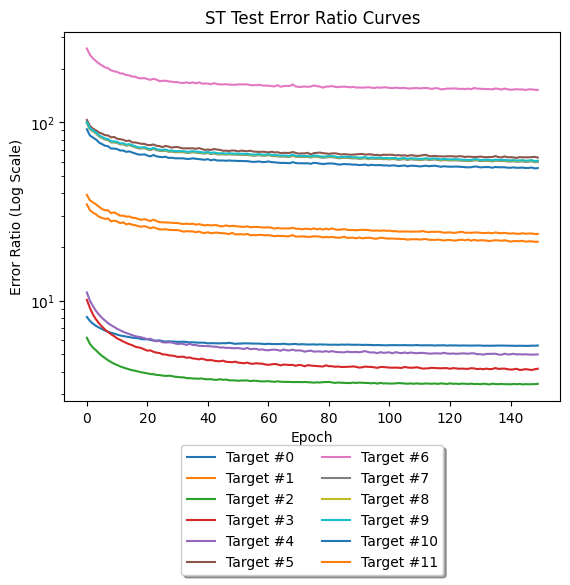

In [45]:
for i, p in enumerate(err_curves):
    plt.plot(p, label="Target #"+str(i))
plt.title("ST Test Error Ratio Curves")
plt.xlabel("Epoch")
plt.ylabel("Error Ratio (Log Scale)")
plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
plt.show()

## Learning Rate Grid Search

In [28]:
lrs = [5e-6, 1e-5, 1.5e-5, 2e-5, 2.5e-5, 3e-5, 3.5e-5, 4e-5, 4.5e-5]
results = {}
for l in lrs:
    batch_results = []
    for i in range(12):
        _, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, TARGET_LABEL=i, epochs=150, batch_size=256, schedule=l)
        train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]
        error_ratios = val_acc / chemical_accuracy[i]
        print("TARGET:",i,"Error Ratio:", error_ratios[-1])
        batch_results.append(error_ratios[-1])
    results[l] = batch_results

  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.554051]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [88.63844]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.765303]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [13.440478]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [15.101503]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [139.35402]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [264.80072]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [63.612442]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [64.294785]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [64.977]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [59.0388]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [47.41336]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.233465]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [91.307915]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.58284]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [14.238322]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [16.138279]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [135.58022]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [250.25516]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [60.53234]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [59.604927]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [60.455315]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [54.945812]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [48.166103]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.4615135]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [92.09975]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.2952104]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [15.200705]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [16.173038]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [133.45396]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [234.81155]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [54.854275]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [55.71133]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [56.1783]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [52.440548]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [50.99604]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.186853]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [90.56274]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.122982]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [15.240334]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [16.878801]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [139.18051]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [227.01483]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [53.611156]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [54.696747]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [55.610905]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [51.050224]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [46.230713]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.052409]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [90.73502]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.1307783]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [14.6491585]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [16.925667]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [148.28555]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [223.35571]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [53.864662]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [53.226265]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [53.470493]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [49.92472]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [46.682987]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.067356]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [91.16823]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.2059536]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [14.490461]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [17.76072]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [144.8446]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [236.4212]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [51.47559]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [51.910892]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [52.33507]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [45.65701]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [44.26392]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.12876]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [91.72639]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.0836825]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [14.563806]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.147827]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [153.86215]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [233.22517]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [48.092415]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [50.07257]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [48.150677]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [45.791225]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [44.141296]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.019812]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [90.05022]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.180863]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [14.522864]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.004364]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [154.99055]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [223.36743]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [50.624126]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [47.496784]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [47.510746]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [44.739967]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [41.379704]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.180248]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [87.61504]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.426798]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [16.250835]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [17.60443]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [148.46107]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [218.22261]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [47.78252]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [48.92607]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [46.8531]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [47.772945]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [42.98751]


In [32]:
lrs = [5e-5, 5.5e-5, 6.5e-5, 7e-5, 7.5e-5, 8.5e-5, 9e-5]
results2 = {}
for l in lrs:
    batch_results = []
    for i in range(12):
        _, QM9_metrics = train_QM9_predictor(QM9_net, QM9_params, TARGET_LABEL=i, epochs=150, batch_size=256, schedule=l)
        train_loss, val_acc = QM9_metrics[:,0], QM9_metrics[:,1:]
        error_ratios = val_acc / chemical_accuracy[i]
        print("TARGET:",i,"Error Ratio:", error_ratios[-1])
        batch_results.append(error_ratios[-1])
    results2[l] = batch_results

  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.586275]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [90.68943]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.039441]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [14.351629]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [17.720654]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [145.33214]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [223.02545]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [47.90964]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [50.66745]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [50.04042]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [47.730568]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [44.118805]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.4276495]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [92.45834]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.147587]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [14.833796]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.064001]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [155.2584]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [221.43666]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [50.18539]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [51.31859]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [50.104507]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [44.27478]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [44.67112]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.9313545]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [94.480576]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.439823]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [16.345682]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.1709]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [145.28293]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [250.58913]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [47.324436]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [47.14949]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [48.89805]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [47.17749]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [43.527836]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.542181]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [95.2841]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.1272793]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [17.255907]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.355616]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [134.37495]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [239.39326]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [50.62065]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [49.071293]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [50.405838]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [48.224255]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [45.142815]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.214418]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [89.30744]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.108229]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [17.213247]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.86234]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [149.76488]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [263.3942]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [51.60295]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [49.297287]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [50.01536]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [48.46165]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [51.04422]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [9.883605]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [92.066]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.4320717]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [18.656494]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.9729]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [139.12721]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [272.3142]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [46.530247]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [47.40252]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [47.96257]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [44.478817]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [41.650127]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 0 Error Ratio: [10.147083]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 1 Error Ratio: [93.33251]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 2 Error Ratio: [6.4589615]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 3 Error Ratio: [16.755552]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 4 Error Ratio: [18.32513]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 5 Error Ratio: [136.62572]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 6 Error Ratio: [287.88312]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 7 Error Ratio: [48.124702]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 8 Error Ratio: [51.763893]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 9 Error Ratio: [51.199062]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 10 Error Ratio: [45.891705]


  0%|          | 0/150 [00:00<?, ?it/s]

TARGET: 11 Error Ratio: [43.770935]


In [33]:
results2

{5e-05: [Array([9.586275], dtype=float32),
  Array([90.68943], dtype=float32),
  Array([6.039441], dtype=float32),
  Array([14.351629], dtype=float32),
  Array([17.720654], dtype=float32),
  Array([145.33214], dtype=float32),
  Array([223.02545], dtype=float32),
  Array([47.90964], dtype=float32),
  Array([50.66745], dtype=float32),
  Array([50.04042], dtype=float32),
  Array([47.730568], dtype=float32),
  Array([44.118805], dtype=float32)],
 5.5e-05: [Array([9.4276495], dtype=float32),
  Array([92.45834], dtype=float32),
  Array([6.147587], dtype=float32),
  Array([14.833796], dtype=float32),
  Array([18.064001], dtype=float32),
  Array([155.2584], dtype=float32),
  Array([221.43666], dtype=float32),
  Array([50.18539], dtype=float32),
  Array([51.31859], dtype=float32),
  Array([50.104507], dtype=float32),
  Array([44.27478], dtype=float32),
  Array([44.67112], dtype=float32)],
 6.5e-05: [Array([9.9313545], dtype=float32),
  Array([94.480576], dtype=float32),
  Array([6.439823], dtyp

In [29]:
results

{5e-06: [Array([10.554051], dtype=float32),
  Array([88.63844], dtype=float32),
  Array([6.765303], dtype=float32),
  Array([13.440478], dtype=float32),
  Array([15.101503], dtype=float32),
  Array([139.35402], dtype=float32),
  Array([264.80072], dtype=float32),
  Array([63.612442], dtype=float32),
  Array([64.294785], dtype=float32),
  Array([64.977], dtype=float32),
  Array([59.0388], dtype=float32),
  Array([47.41336], dtype=float32)],
 1e-05: [Array([10.233465], dtype=float32),
  Array([91.307915], dtype=float32),
  Array([6.58284], dtype=float32),
  Array([14.238322], dtype=float32),
  Array([16.138279], dtype=float32),
  Array([135.58022], dtype=float32),
  Array([250.25516], dtype=float32),
  Array([60.53234], dtype=float32),
  Array([59.604927], dtype=float32),
  Array([60.455315], dtype=float32),
  Array([54.945812], dtype=float32),
  Array([48.166103], dtype=float32)],
 1.5e-05: [Array([9.4615135], dtype=float32),
  Array([92.09975], dtype=float32),
  Array([6.2952104], dtyp

In [31]:
for k, v in results.items():
    print(k, jnp.mean(jnp.array(v)))

5e-06 69.83258
1e-05 67.33672
1.5e-05 64.80635
2e-05 63.782238
2.5e-05 63.941956
3e-05 63.883415
3.5e-05 63.665497
4e-05 62.323956
4.5e-05 61.506935


In [34]:
for k, v in results2.items():
    print(k, jnp.mean(jnp.array(v)))

5e-05 62.267662
5.5e-05 63.18174
6.5e-05 64.60981
7e-05 63.73318
7.5e-05 67.10719
8.5e-05 65.456406
9e-05 67.5232


# ECFP4 Embeddings

In [35]:
def to_ecfp4(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    ecfp4 = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    return jnp.array(ecfp4, dtype=jnp.uint8)

In [36]:
def load_as_ecfp4(fpath): # this takes a little bit to run becuase it's CPU based.
    smiles_strings = sanitize_data(*load_data(fpath))[0]
    encoded_bitstrings = smiles_strings.map(to_ecfp4).values
    return jnp.stack([i for i in encoded_bitstrings])

In [37]:
TRAIN_FPRINTS = load_as_ecfp4("train.csv")
VAL_FPRINTS = load_as_ecfp4("val.csv")
TEST_FPRINTS = load_as_ecfp4("test.csv")

[14:25:37] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 2 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 6 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:25:37] Explicit valence for atom # 8 C, 5, is g

The prior work paper (Farber 2017) achieved good performance on all of the tasks using SKLearn's RandomForest implementation with 120 predictors. 
No other details were provided and the codebase was never released, so the defaults for RF are used otherwise.

In [38]:
for i in range(12):

    regr = RandomForestRegressor(n_estimators=120, random_state=0, n_jobs=-1)
    
    regr.fit(TRAIN_FPRINTS, TRAIN_Y[:,i])
    
    predictions = regr.predict(TEST_FPRINTS)
    
    print(i, TRAIN_MAD[i] * jnp.mean(jnp.abs(TEST_Y[:,i] - predictions), axis=0) / chemical_accuracy[i])

0 5.2838874
1 37.451096
2 3.8948665
3 4.452923
4 5.044945
5 78.46795
6 211.74692
7 86.04538
8 86.81485
9 87.349846
10 79.38837
11 29.648144
